# **Age, Gender and Race Prediction**

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as imgen
from keras.models import load_model, Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing import image
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error

## Reading and fixing Dataset

In [2]:
#read
data = pd.read_csv("../DataSets/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
data.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...

In [3]:
#shape
data.shape

(23705, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [5]:
# Getting Image data

def toPixels(pixels):
    arr = np.array(pixels.split(),"float64")
    arr = arr.reshape(48,48)
    
    return arr

In [6]:
%%time
data["pixels"] = data["pixels"].apply(toPixels)

CPU times: user 16.2 s, sys: 205 ms, total: 16.4 s
Wall time: 16.5 s


In [7]:
pixels = np.reshape(data["pixels"].to_list(), (data.shape[0],48,48,1))

In [8]:
pixels.shape

(23705, 48, 48, 1)

# **Age Prediction Model**

### Generating Datsets for Age Prediction

In [9]:
x_train_age,x_test_age, y_train_age,y_test_age = train_test_split(pixels,np.array(data["age"]),random_state = 42, test_size = 0.2)
x_train_age,x_val_age, y_train_age,y_val_age = train_test_split(x_train_age,y_train_age,random_state = 21, test_size = 0.15)

In [10]:
print(x_train_age.shape,y_train_age.shape, x_test_age.shape,x_val_age.shape)

(16119, 48, 48, 1) (16119,) (4741, 48, 48, 1) (2845, 48, 48, 1)


**Image data Generator.**

In [11]:
traingen = imgen(rescale=1./255,
                zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip= True
                )
valgen = imgen(rescale=1./255,
                zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip= True
                )

testgen = imgen(rescale=1./255)

In [12]:
age_train_ds = traingen.flow(x_train_age,y_train_age,
                        batch_size = 32
                       )

age_val_ds = valgen.flow(x_val_age,y_val_age,
                        batch_size = 32
                       )

age_test_ds = testgen.flow(x_test_age,y_test_age,
                     batch_size = 32,
                    shuffle=False
                     )

**Visualizing one batch.**

In [13]:
def showImagesAge(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Age is {}".format(label[i]))
        plt.axis('off')
    plt.show()

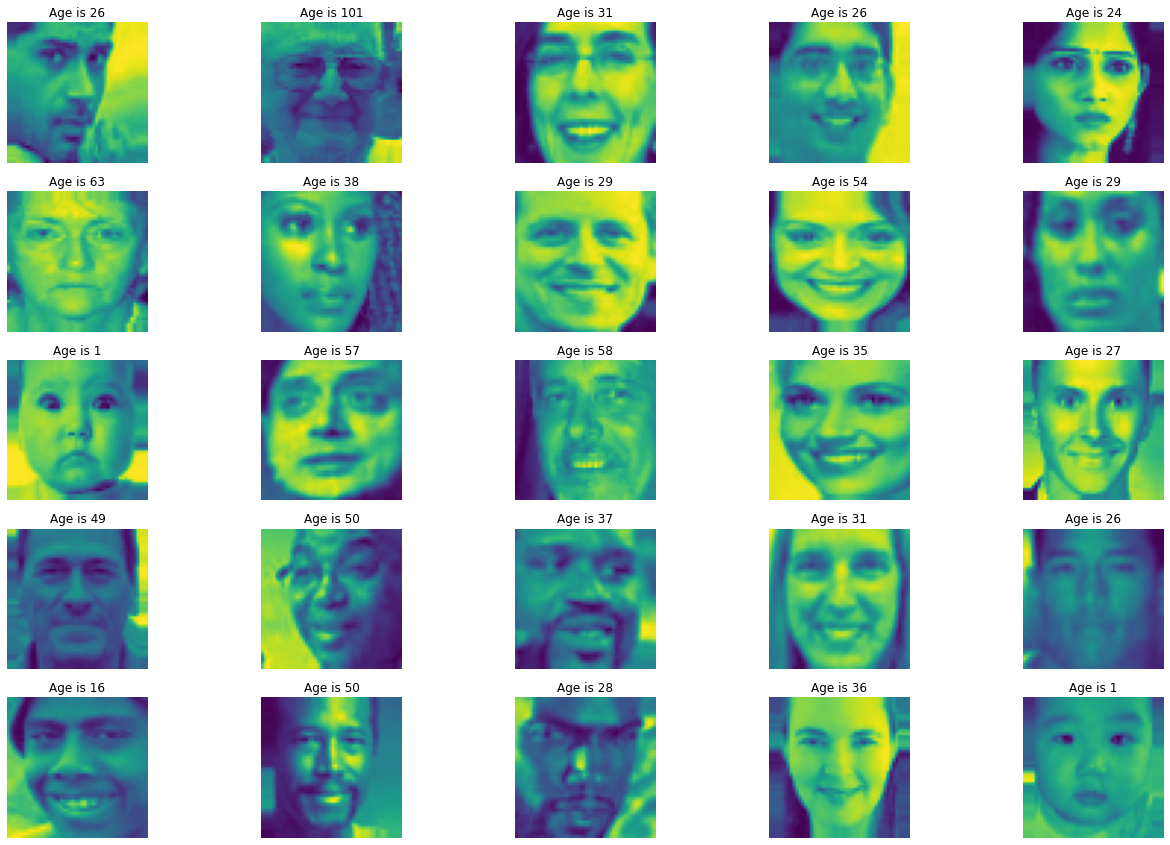

In [14]:
X,Y = next(age_train_ds)

showImagesAge(X,Y)

### Model

In [15]:
image_input = keras.Input(shape=(48,48,1))

l1 = Conv2D(32,(3,3), activation="relu")(image_input)
l2 = Conv2D(32,(3,3), activation="relu")(l1)
l3 = MaxPooling2D(pool_size=(2, 2))(l2)

l4 = Dropout(0.30)(l3)

l5 = Conv2D(64,(3,3), activation="relu")(l4)
l6 = Conv2D(128,(3,3), activation="relu")(l5)

#l7 = BatchNormalization()(l6)

l8 = Flatten()(l6)
l9 = Dense(256, activation= "relu")(l8)
image_output = Dense(1)(l9)
model_age = keras.Model(image_input, image_output)

In [16]:
model_age.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856 

In [17]:
# Compiling the model
model_age.compile(optimizer='adam', loss = 'mse', metrics=[keras.metrics.mean_absolute_error])

**Defining callbacks.**

In [18]:
my_calls = [keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',patience=3),
            keras.callbacks.ModelCheckpoint("Model_age.h5",verbose=1,save_best_only=True)]

**Training the model for age.**

In [19]:
hist_age = model_age.fit(age_train_ds,epochs=35,validation_data=age_val_ds,callbacks=my_calls)

Epoch 1/35
504/504 [==============================] - 17s 23ms/step - loss: 446.8214 - mean_absolute_error: 16.1044 - val_loss: 228.2585 - val_mean_absolute_error: 11.7687

Epoch 00001: val_loss improved from inf to 228.25848, saving model to Model_age.h5
Epoch 2/35
504/504 [==============================] - 11s 21ms/step - loss: 251.7529 - mean_absolute_error: 11.8754 - val_loss: 170.5610 - val_mean_absolute_error: 9.8018

Epoch 00002: val_loss improved from 228.25848 to 170.56097, saving model to Model_age.h5
Epoch 3/35
504/504 [==============================] - 11s 22ms/step - loss: 183.8121 - mean_absolute_error: 10.1148 - val_loss: 144.7457 - val_mean_absolute_error: 8.7458

Epoch 00003: val_loss improved from 170.56097 to 144.74571, saving model to Model_age.h5
Epoch 4/35
504/504 [==============================] - 11s 21ms/step - loss: 156.5024 - mean_absolute_error: 9.2539 - val_loss: 129.3074 - val_mean_absolute_error: 8.1899

Epoch 00004: val_loss improved from 144.74571 to 12

**Test for age prediction**

In [20]:
model_age.evaluate(age_test_ds,verbose=1)

149/149 [==============================] - 2s 15ms/step - loss: 83.1998 - mean_absolute_error: 6.7299


[83.1998062133789, 6.729865074157715]

**Loss and MAE**

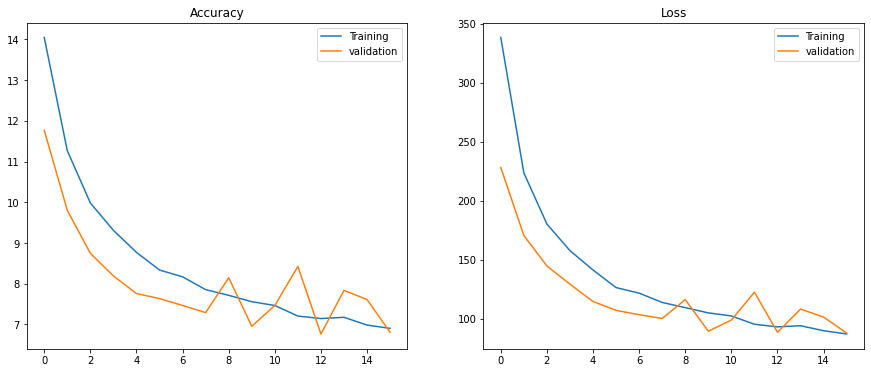

In [21]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_age.epoch,hist_age.history['mean_absolute_error'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_mean_absolute_error'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_age.epoch,hist_age.history['loss'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Verifying the Predictions**

In [22]:
pred_Age = model_age.predict(age_test_ds, verbose=1)

149/149 [==============================] - 2s 13ms/step


**Plotting predicetd v/s actual ages**

In [23]:
pred_age = []
for i in pred_Age:
    pred_age.append(np.round(i[0]))

In [24]:
def plotAgePA(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test_age[i])
        plt.xlabel("Actual Age is {}".format(actual[i]))
        plt.ylabel("Prediced is {}".format(pred[i]))
    plt.show()

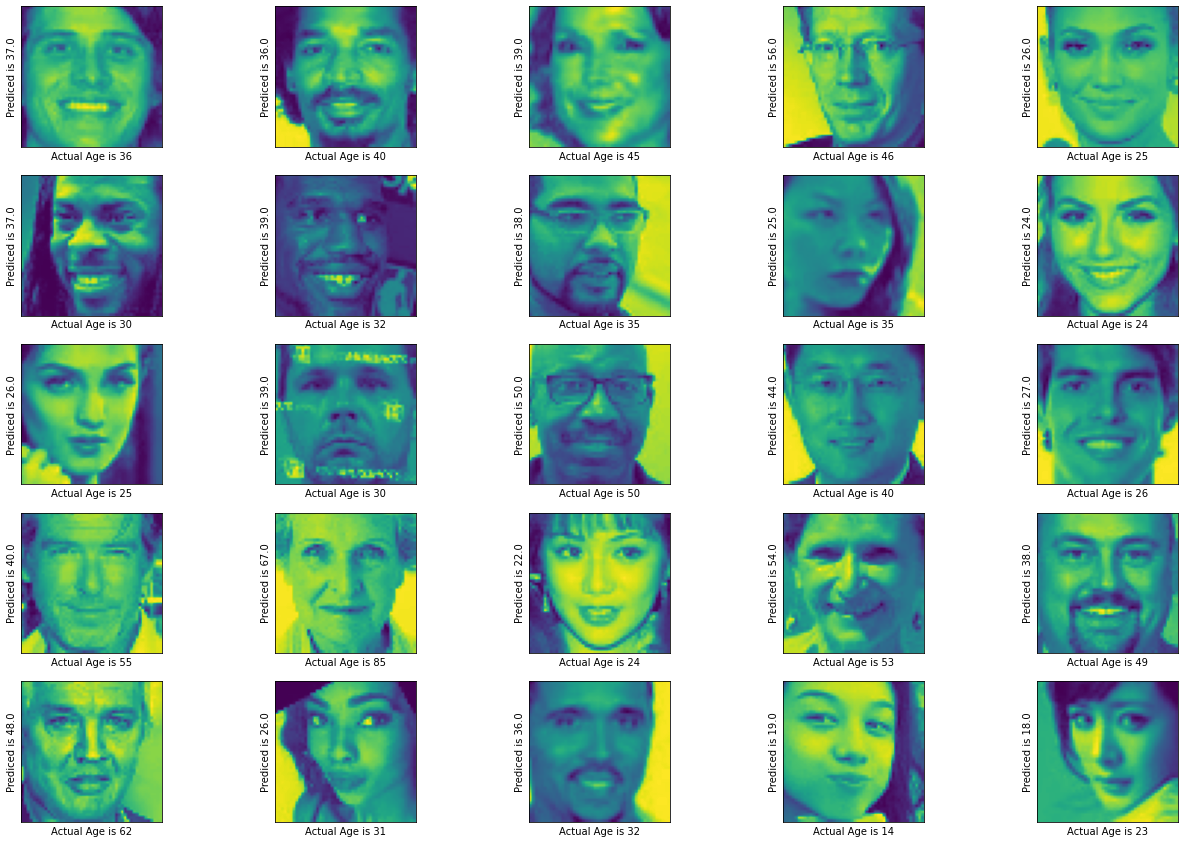

In [25]:
plotAgePA(x_test_age,pred_age,y_test_age)

# **Gender Prediction Model**

### Dataset for Gender Prediction

In [26]:
x_train_gen,x_test_gen, y_train_gen,y_test_gen = train_test_split(pixels,np.array(data["gender"]),random_state = 42, test_size = 0.2)
x_train_gen,x_val_gen, y_train_gen,y_val_gen = train_test_split(x_train_gen,y_train_gen,random_state = 21, test_size = 0.15)

In [27]:
print(x_train_gen.shape,y_train_gen.shape,x_val_gen.shape,y_val_gen.shape)

(16119, 48, 48, 1) (16119,) (2845, 48, 48, 1) (2845,)


**Data Generator**

In [28]:
gender = ["Male","Female"]

In [29]:
gen_train_ds = traingen.flow(x_train_gen,y_train_gen,
                        batch_size = 32
                       )

gen_val_ds = valgen.flow(x_val_gen,y_val_gen,
                        batch_size = 32
                       )

gen_test_ds = testgen.flow(x_test_gen,y_test_gen,
                     batch_size = 32,
                    shuffle=False
                     )

In [30]:
#one batch
def showImagesGender(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Gender is {}".format(gender[label[i]]))
        plt.axis('off')
    plt.show()

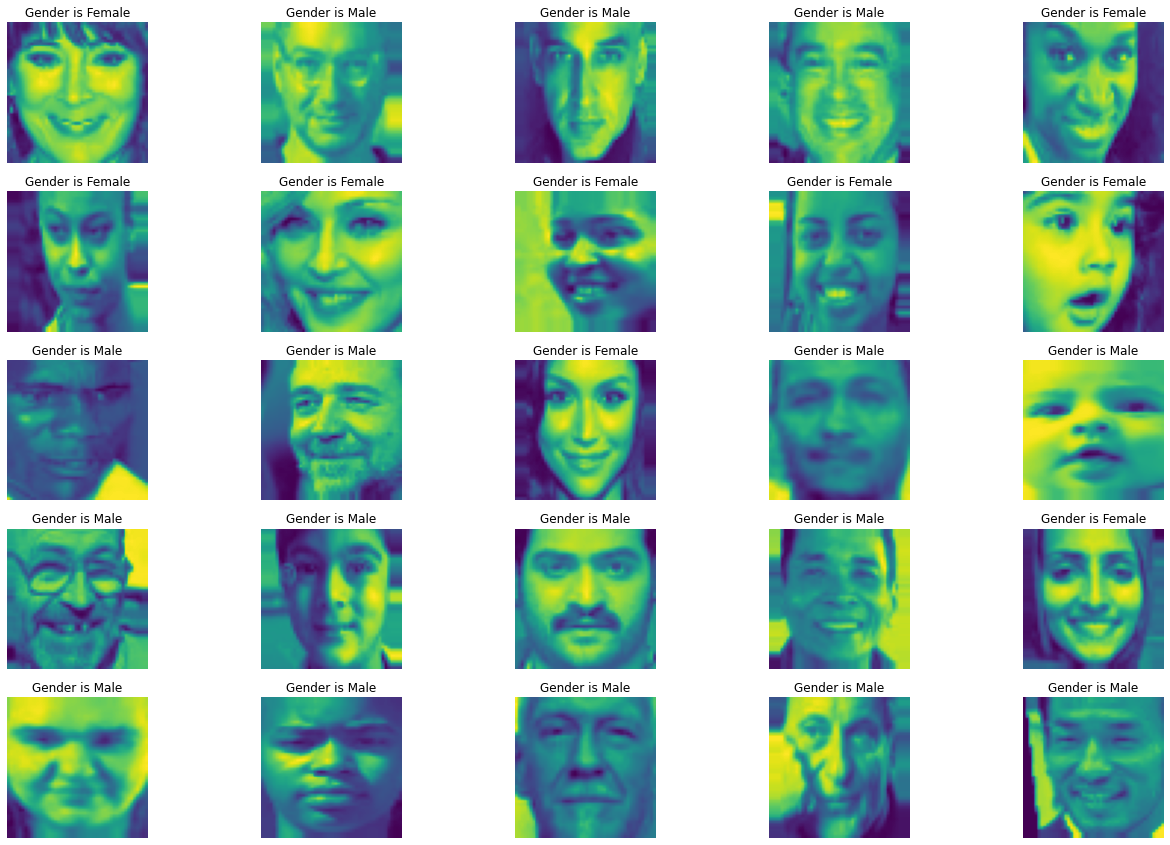

In [31]:
A,b = next(gen_train_ds)
showImagesGender(A,b)

## Model

In [32]:
model_gender = Sequential([
    Conv2D(32,(3,3), activation = "relu", input_shape = (48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    #Conv2D(128,(3,3), activation = "relu"),
    #MaxPooling2D(2,2),
    
    Flatten(),
    
    #Dense(256,activation = 'relu'),
    #Dropout(0.5),
    
    Dense(64,activation = 'relu'),
    Dropout(0.5),
    
    
    Dense(1,activation='sigmoid')
])
model_gender.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0

**compile the model**

In [33]:
model_gender.compile(optimizer='adam',loss = "binary_crossentropy",metrics=['accuracy'])

**Callbacks**

In [34]:
my_calls_1 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint("Model_Gender.h5",verbose=1,save_best_only=True)]

**Train**

In [35]:
hist_gender = model_gender.fit(gen_train_ds,epochs = 23, validation_data = gen_val_ds, callbacks = my_calls_1)

Epoch 1/23
504/504 [==============================] - 8s 15ms/step - loss: 0.6426 - accuracy: 0.6047 - val_loss: 0.4658 - val_accuracy: 0.7895

Epoch 00001: val_loss improved from inf to 0.46577, saving model to Model_Gender.h5
Epoch 2/23
504/504 [==============================] - 8s 15ms/step - loss: 0.4925 - accuracy: 0.7670 - val_loss: 0.3975 - val_accuracy: 0.8211

Epoch 00002: val_loss improved from 0.46577 to 0.39755, saving model to Model_Gender.h5
Epoch 3/23
504/504 [==============================] - 7s 14ms/step - loss: 0.4298 - accuracy: 0.8001 - val_loss: 0.3775 - val_accuracy: 0.8327

Epoch 00003: val_loss improved from 0.39755 to 0.37748, saving model to Model_Gender.h5
Epoch 4/23
504/504 [==============================] - 9s 17ms/step - loss: 0.4062 - accuracy: 0.8110 - val_loss: 0.3660 - val_accuracy: 0.8408

Epoch 00004: val_loss improved from 0.37748 to 0.36599, saving model to Model_Gender.h5
Epoch 5/23
504/504 [==============================] - 7s 15ms/step - loss: 0

**Test**

In [36]:
model_gender.evaluate(gen_test_ds)

149/149 [==============================] - 1s 6ms/step - loss: 0.2545 - accuracy: 0.8874


[0.25448915362358093, 0.8873655200004578]

**Loss and Accuracy**

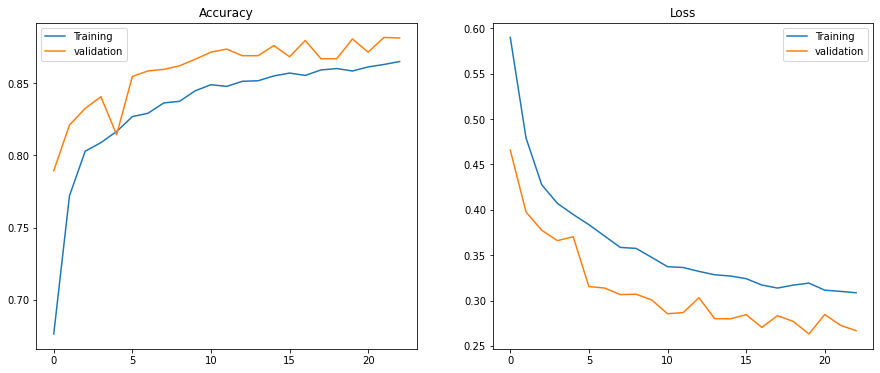

In [37]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_gender.epoch,hist_gender.history['accuracy'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_gender.epoch,hist_gender.history['loss'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [38]:
pred_gender = model_gender.predict(gen_test_ds)

In [39]:
pred_gen = []
for i in pred_gender:
    pred_gen.append(int(np.round(i[0])))

In [40]:
pred_gen[:5]

[1, 0, 1, 0, 0]

In [41]:
print(classification_report(pred_gen,y_test_gen))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2412
           1       0.89      0.87      0.88      2329

    accuracy                           0.89      4741
   macro avg       0.89      0.89      0.89      4741
weighted avg       0.89      0.89      0.89      4741



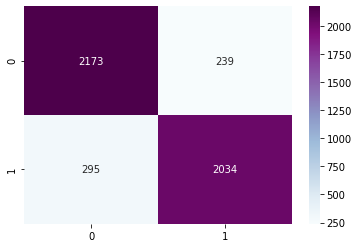

In [42]:
sns.heatmap(confusion_matrix(pred_gen,y_test_gen),annot = True, fmt = 'd', cmap = "BuPu");

In [43]:
def testGender(image,pred,actual):
    plt.figure(figsize=[22,15])
    for i in range(500,525):
        plt.subplot(5,5,(i%25)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image[i])
        plt.xlabel("Actual Gender is {}".format(gender[actual[i]]))
        plt.ylabel("Prediced is {}".format(gender[pred[i]]))
    plt.show()

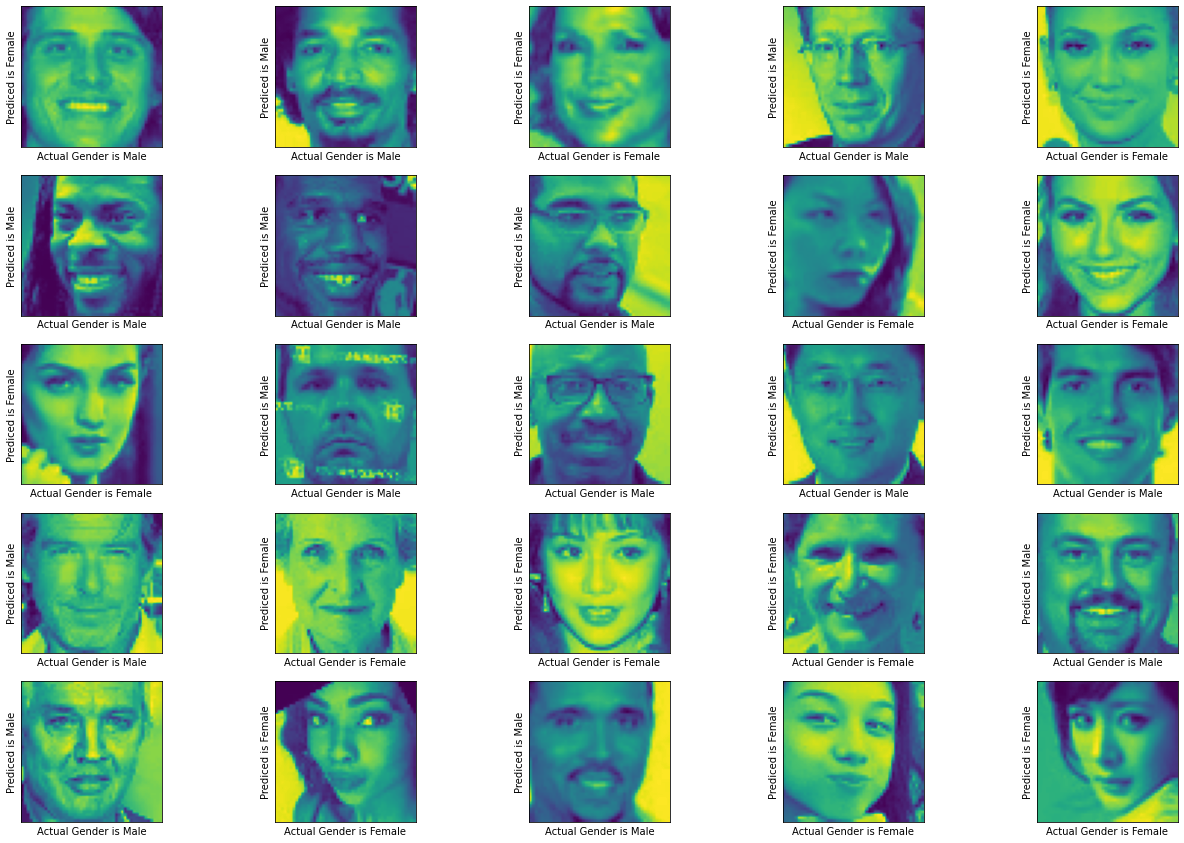

In [44]:
testGender(x_test_gen,pred_gen, y_test_gen)

# **Ethnicity Prediction**

## Data for ethnicity prediction

In [45]:
x_train_et,x_test_et, y_train_et,y_test_et = train_test_split(pixels,np.array(data["ethnicity"]),random_state = 42, test_size = 0.2)
x_train_et,x_val_et, y_train_et,y_val_et = train_test_split(x_train_et,y_train_et,random_state = 21, test_size = 0.15)

In [46]:
print(x_train_et.shape,y_train_et.shape)

(16119, 48, 48, 1) (16119,)


In [47]:
et_train_ds = traingen.flow(x_train_et,y_train_et,
                        batch_size = 32
                       )

et_val_ds = valgen.flow(x_val_et,y_val_et,
                        batch_size = 32
                       )

et_test_ds = testgen.flow(x_test_et,y_test_et,
                     batch_size = 32,
                    shuffle=False
                     )

In [48]:
#one batch
def showImagesEthnicity(img,label):
    plt.figure(figsize=[22,15])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title("Race is {}".format(label[i]))
        plt.axis('off')
    plt.show()

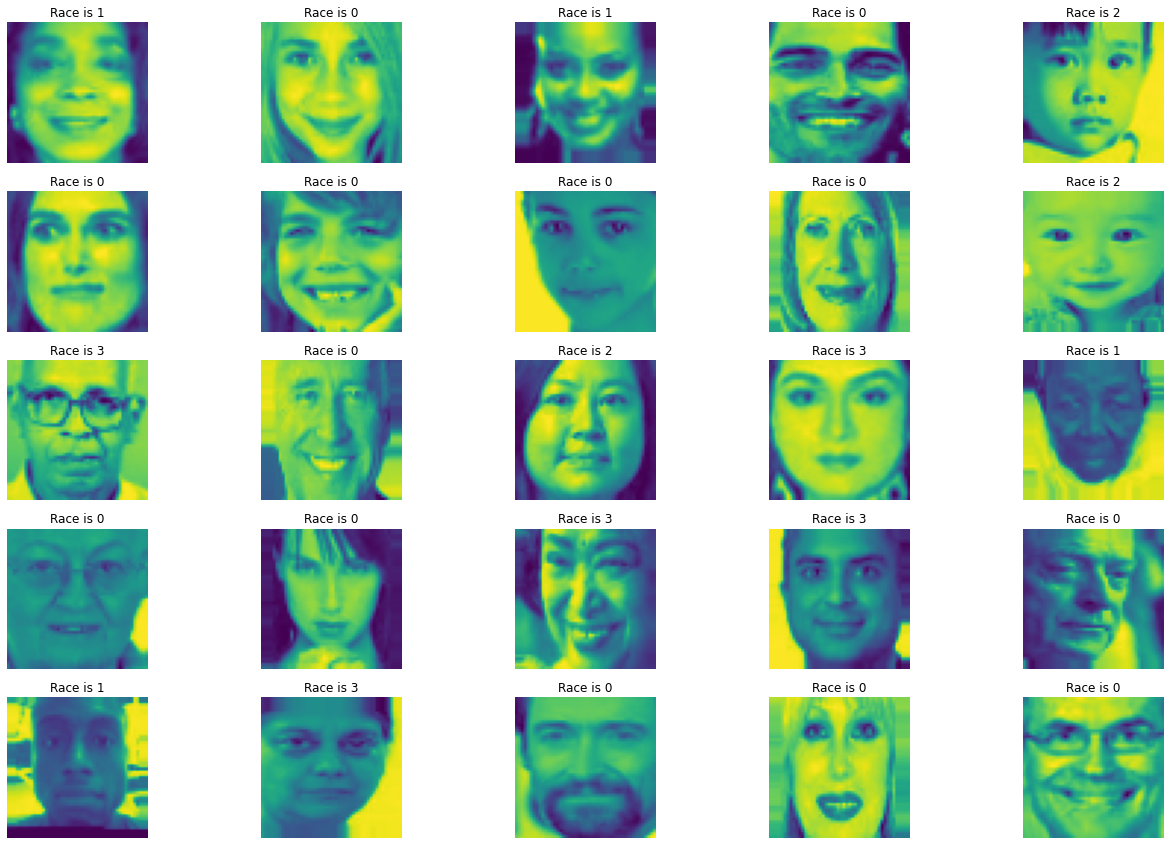

In [49]:
c,d = next(et_train_ds)
showImagesEthnicity(c,d)

## Model

In [50]:
model_et = Sequential([
    Conv2D(32,(3,3), activation = "relu", input_shape = (48,48,1)),
    MaxPooling2D(2,2),
    
    Conv2D(32,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Dropout(0.3),
    
    Conv2D(64,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3), activation = "relu"),
    MaxPooling2D(2,2),
    
    Flatten(),
    
    Dense(256,activation = 'relu'),
    Dropout(0.5),
    
    #Dense(64,activation = 'relu'),
    #Dropout(0.5),
    
    
    Dense(5,activation='softmax')
])
model_et.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)         

**Compile the model**

In [51]:
model_et.compile(optimizer='adam',loss = "sparse_categorical_crossentropy",metrics=['accuracy'])

**Callbacks**

In [52]:
my_calls_2 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint("Model_Ethnicity.h5",verbose=1,save_best_only=True)]

**Train**

In [53]:
hist_et = model_et.fit(et_train_ds,epochs=22,validation_data=et_val_ds,callbacks=my_calls_2)

Epoch 1/22
504/504 [==============================] - 9s 16ms/step - loss: 1.4387 - accuracy: 0.4232 - val_loss: 1.1974 - val_accuracy: 0.5283

Epoch 00001: val_loss improved from inf to 1.19741, saving model to Model_Ethnicity.h5
Epoch 2/22
504/504 [==============================] - 8s 16ms/step - loss: 1.1899 - accuracy: 0.5340 - val_loss: 0.9919 - val_accuracy: 0.6425

Epoch 00002: val_loss improved from 1.19741 to 0.99193, saving model to Model_Ethnicity.h5
Epoch 3/22
504/504 [==============================] - 7s 14ms/step - loss: 1.0367 - accuracy: 0.6124 - val_loss: 0.9030 - val_accuracy: 0.6773

Epoch 00003: val_loss improved from 0.99193 to 0.90296, saving model to Model_Ethnicity.h5
Epoch 4/22
504/504 [==============================] - 9s 17ms/step - loss: 0.9772 - accuracy: 0.6369 - val_loss: 0.8915 - val_accuracy: 0.6833

Epoch 00004: val_loss improved from 0.90296 to 0.89152, saving model to Model_Ethnicity.h5
Epoch 5/22
504/504 [==============================] - 8s 16ms/st

**Test**

In [54]:
model_et.evaluate(et_test_ds)

149/149 [==============================] - 1s 4ms/step - loss: 0.7457 - accuracy: 0.7302


[0.7457401156425476, 0.730225682258606]

**Loss and Accuracy**

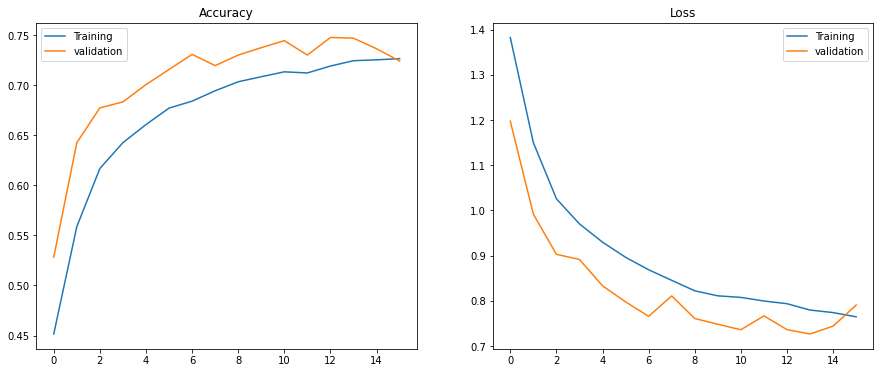

In [55]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_et.epoch,hist_et.history['accuracy'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_et.epoch,hist_et.history['loss'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [56]:
pred_et = model_et.predict(et_test_ds)

In [57]:
pred_et = [np.argmax(i) for i in pred_et]
pred_et[:5]

[1, 1, 1, 3, 0]

In [58]:
pd.DataFrame(pred_et).value_counts()

0    2073
1    1346
3     753
2     537
4      32
dtype: int64

In [59]:
pd.DataFrame(y_test_et).value_counts()

0    2047
1     904
3     804
2     657
4     329
dtype: int64

In [60]:
print(classification_report(pred_et,y_test_et))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      2073
           1       0.93      0.62      0.74      1346
           2       0.67      0.82      0.74       537
           3       0.64      0.68      0.66       753
           4       0.04      0.38      0.07        32

    accuracy                           0.73      4741
   macro avg       0.62      0.66      0.60      4741
weighted avg       0.79      0.73      0.75      4741



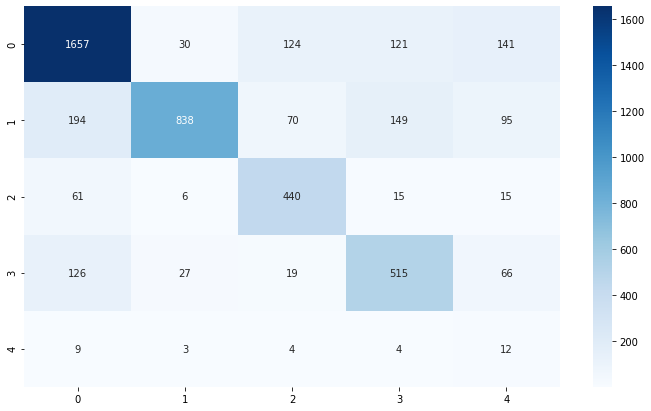

In [61]:
plt.figure(figsize=[12,7])
sns.heatmap(confusion_matrix(pred_et,y_test_et),annot=True,fmt='d',cmap="Blues");

**Not performing well at all, will get back to this**